In [1]:
%load_ext autoreload
%autoreload 2
import os, sys, inspect
sys.path.insert(1, os.path.join(sys.path[0], '../'))
import numpy as np
from ar import generate_process, generate_process_heteroskedastic, fit_ar_model, predict
from utils import plot_coverage_size, plot_sets, plot_vertical_spread
from core import standard_weighted_quantile
from core import trailing_window, aci, projected_gradient_descent, mirror_descent
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
from tqdm import tqdm
sns.set_theme(context="notebook", palette="pastel", style="white")
sns.set_style({'axes.spines.right': False, 'axes.spines.top': False})

In [164]:
# Check that beta is valid
T_train = 1000
T_test = 20000
changepoint_loc = 600
T_burnin = 1000
weight_length = T_burnin
beta1 = np.array([0,0,0])
beta2 = np.array([0,0,0.99999])
std = 1
Y_train = generate_process(T_train, beta1, std)
if changepoint_loc is None:
    Y_test = generate_process(T_test, beta1, std)
else:
    Y_test = np.concatenate([generate_process(changepoint_loc, beta1, std), generate_process(T_test-changepoint_loc, beta2, std)])

root_mags = np.abs(np.roots([1,] + list(-beta1)))
assert np.all(root_mags <= 1.)

root_mags = np.abs(np.roots([1,] + list(-beta2)))
assert np.all(root_mags <= 1.)

# Fit and predict
betahat = fit_ar_model(Y_train,3)
Yhat_test = predict(Y_test, betahat)
scores = np.abs(Y_test - Yhat_test)

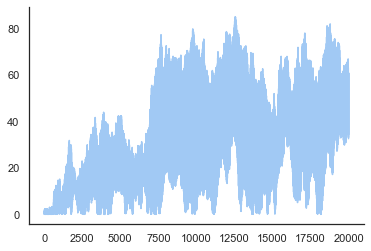

In [165]:
plt.plot(scores)

In [166]:
args = {
    "scores": scores,
    "alpha": 0.1,
    "aci_lr": 1e-2,
    "pgd_lr": 1e-5,
    "fw_lr": 1e-5,
    "md_lr": 5e-4,
    "monotone": False,
    "reg": 1,
    "T_burnin": T_burnin,
    "weight_length": weight_length,
    "aci_window_length": T_test,
    "aci_no_infinite": True,
    "pgd_no_infinite": False,
    "md_no_infinite": True,
    "smoothing": 100, # Results smoothing
    "epsilon": 1e-6 # Used everywhere we want a small number
}

results = {
    "trail" : trailing_window(**args),
    "aci": aci(**args),
    "pgd": projected_gradient_descent(**args),
    #"md": mirror_descent(**args),
    #"fw" : frank_wolfe(**args)
}

100%|████████████████████████████████████████████████████████████████████████| 20000/20000 [00:10<00:00, 1888.89it/s]


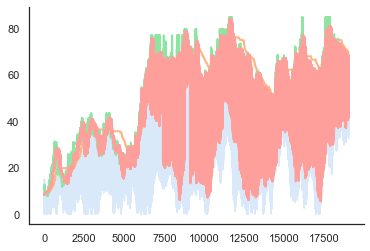

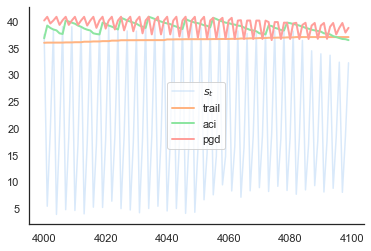

In [168]:
window_to_plot = np.arange(4000,4100)
plt.figure()
plt.plot(scores[T_burnin+1:], label=r'$s_t$', alpha=0.4)
[plt.plot(results[key]["q"][T_burnin+1:], label=key, linewidth=2) for key in results.keys()]

plt.figure()
plt.plot(window_to_plot, scores[window_to_plot], label=r'$s_t$', alpha=0.4)
[plt.plot(window_to_plot, results[key]["q"][window_to_plot], label=key, linewidth=2) for key in results.keys()]
plt.legend()

In [171]:
for key in results.keys():
    print(f"Method: {key}  |  ", "Coverage: ", (results[key]["q"][T_burnin+1:] >= scores[T_burnin:-1]).mean())

Method: trail  |   Coverage:  0.8599926311911154
Method: aci  |   Coverage:  0.9508921522185378
Method: pgd  |   Coverage:  0.8756250328964682


-0.1 0.9
(array([0. , 0.9]), array([444, 556]))
0.9


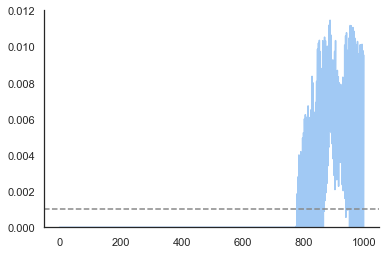

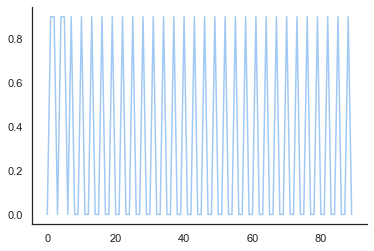

In [173]:
offset = 3600
method = "pgd"
plt.plot(results[method]["weights"][changepoint_loc+offset,:-1])
plt.axhline(y = 1/weight_length, color="#888888", linestyle="dashed")
plt.ylim([0,None])
plt.figure()
plt.plot(results[method]["grads"][changepoint_loc+offset,10:100])
print(results[method]["grads"].min(), results[method]["grads"].max())
print(np.unique(results[method]["grads"][changepoint_loc+offset], return_counts=True))
print(results[method]["grads"][changepoint_loc+offset,-1])

38.873775838719695
1.0


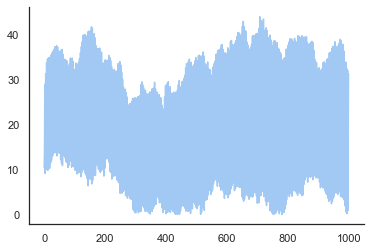

In [174]:
print(
    standard_weighted_quantile(
        scores[changepoint_loc+offset-weight_length:changepoint_loc+offset-1], 
        results[method]["weights"][changepoint_loc+offset,:-1], 
        0.9
    )
)
print(results[method]["weights"][changepoint_loc+offset,:-1].sum())
plt.plot(scores[changepoint_loc+offset-weight_length:changepoint_loc+offset-1])